In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from automouse_model import automouseTKV_model_2 

In [3]:
data_path = r'C:\Users\UAB\data\AllNIIimages\\'
images = []
segmentations = []
for f in os.listdir(data_path):
  if '_K' in f:
    continue
  else:
    images.append(f)
    segmentations.append(f.replace('.nii', '_K.nii'))

print(images[0], segmentations[0])
images = np.array(images)
segmentations = np.array(segmentations)

indices = np.array(range(len(images))) # we will use this in the next step.

101934_0_96_L_M.nii 101934_0_96_L_M_K.nii


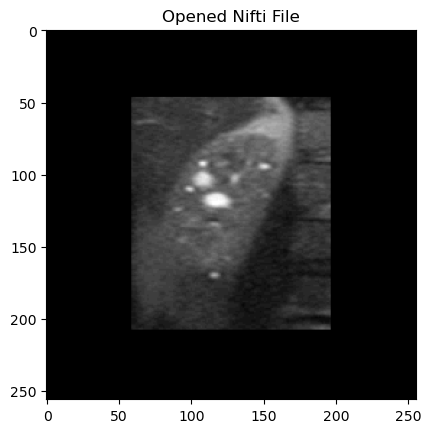

In [4]:
train, test = train_test_split(indices, test_size=0.25) # TODO: split indices into training and test partitions
path = (data_path+'\\'+images[train][0])
nifti_image = nib.load(path)
nifti_data = nifti_image.get_fdata()
nifti_slice = nifti_data[:,:,50]
plt.imshow(nifti_slice, cmap='gray')
plt.title('Opened Nifti File')
plt.show()

In [5]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')
    
def retrieve_images_and_segmentations(data_path, images, segmentations, size=(256,256)):
  x = []
  y = []
  for i in range(len(images)):
    seg = read_nifti_file(data_path+segmentations[i])
    img = read_nifti_file(data_path+images[i])
    assert img.shape == seg.shape
    seg = resize(seg,(size[0], size[1], seg.shape[-1]))
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(seg.shape[-1]):
      # ignore slices that don't have a segmentation
      if np.sum(seg[:,:,j]) == 0:
        continue
      x.append(img[:,:,j])
      y.append(seg[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]
  y = np.array(y)[:,:,:,np.newaxis]

  # randomly shuffle slices
  m = x.shape[0]
  order = np.random.permutation(m)

  return x[order], y[order]

def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

In [6]:
train, valid = train_test_split(train, test_size=0.25)
example_image = read_nifti_file(data_path+'\\'+images[train][0]) # TODO: read in the first image from the training partition
example_segmentation = read_nifti_file(data_path+'\\'+segmentations[train][0])  # TODO: read in the first segmentation from the training partition

print(example_image.shape, example_segmentation.shape)

(256, 256, 141) (256, 256, 141)


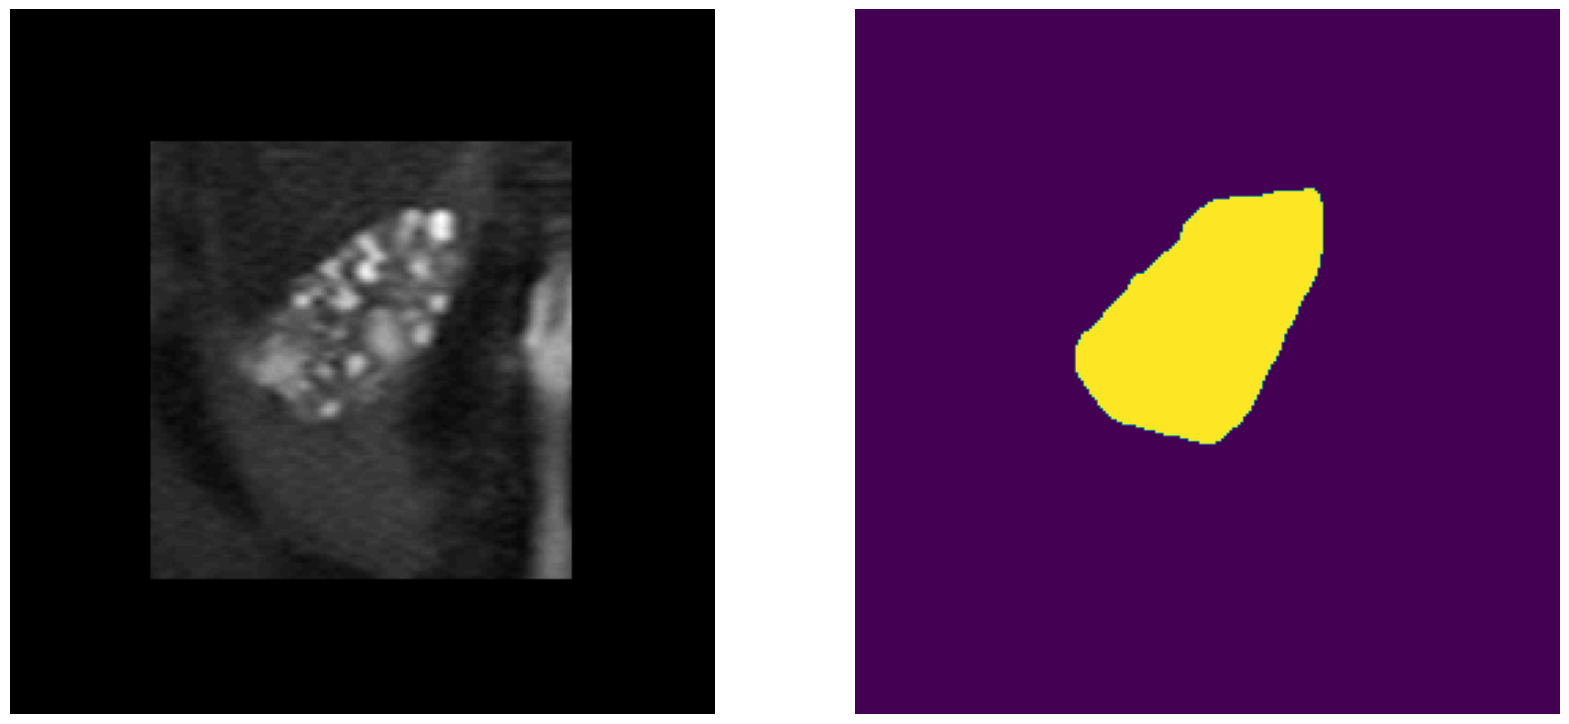

In [7]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(example_image[:,:,40], cmap='gray') # TODO: display the first slice from the image
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(example_segmentation[:,:,40])  # TODO: display the first slice from the segmentation
ax2.axis('off')
plt.show()

In [8]:
x_train, y_train = retrieve_images_and_segmentations(data_path, images[train], segmentations[train]) #TODO: get the matrices for the training partition
print(x_train.shape, y_train.shape)

(10787, 256, 256, 1) (10787, 256, 256, 1)


In [9]:
x_valid, y_valid = retrieve_images_and_segmentations(data_path, images[valid], segmentations[valid]) #TODO: get the matrices for the validation partition
print(x_valid.shape, y_valid.shape)

(3490, 256, 256, 1) (3490, 256, 256, 1)


In [10]:
x_test, y_test = retrieve_images_and_segmentations(data_path, images[test], segmentations[test]) #TODO: get the matrices for the test partition
print(x_test.shape, y_test.shape)

(4886, 256, 256, 1) (4886, 256, 256, 1)


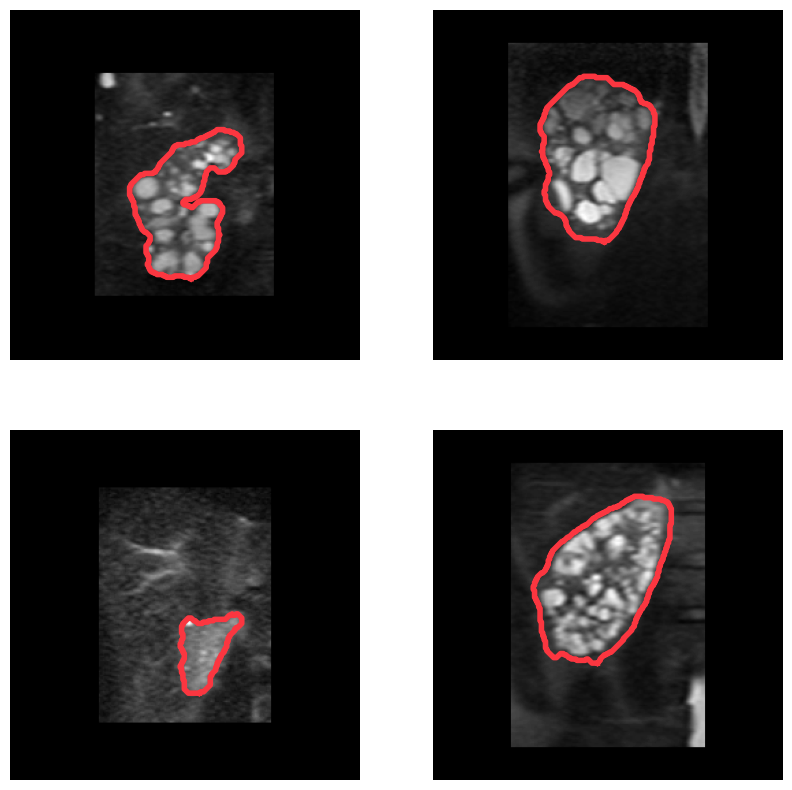

In [11]:
visualise_data(x_train, y_train)
plt.show()

In [12]:

model = automouseTKV_model_2() #TODO: instantiate the custom_unet object


In [ ]:

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])


In [26]:

history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=10)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 1, 512, 512), found shape=(None, 256, 256, 1)


In [13]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\UAB\anaconda3\envs\TF23\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 1, 256, 256), found shape=(None, 256, 256, 1)
